**Tabla de contenido**

- [Introducción](#Introduccion)
- [Requisitos](#Requisitos)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#EDA)
- [Preprocesamiento](#Preprocesamiento)
- [Respuestasa preguntas EDA](#Respuestasa-preguntas-EDA)
- [Feature engineering](#Feature-engineering)
- [Modelado](#Modelado)
    - [Árboles de decisión](#Arboles-de-decision)
    - [hyperparameter optimization](#hyperparameter-optimization)
        - [RandomForestRegressor](#RandomForestRegressor)
    - [Evaluación](#Evaluacion)
- [Cálculo del crecimiento proyectado](#Calculo-del-crecimiento-proyectado)

# Introduccion

El objetivo de este cuaderno es preparar los datos necesarios para entrenar modelos que estimen la cantidad de unidades semanales por cliente. A partir de esta estimación, se calculará el crecimiento previsto en el número de unidades a entregar durante las próximas seis semanas, desglosado por cliente. Inicialmente, identificamos que se trata de un problema de series de tiempo, donde cada cliente representa una serie temporal independiente.

Sin más preámbulos, ¡comencemos!

# Requisitos

El siguiente cuaderno fue desarrollado en un entorno de anaconda con las siguientes características:

- Python 3.12.11
- pandas: 2.3.3
- numpy: 1.26.4
- matplotlib: 3.10.7
- seaborn: 0.13.2
- plotly: 5.24.1
- xgboost: 3.1.1
- scikit-learn: 1.7.2
- optuna: 4.5.0

Comandos para instalar.

- pip install pandas==2.3.3
- pip install numpy==1.26.4
- pip install matplotlib==3.10.7
- pip install seaborn==0.13.2
- pip install plotly==5.24.1
- pip install nbformat ipywidgets
- pip install xgboost==3.1.1
- pip install scikit-learn==1.7.2
- pip install optuna==4.5.0


# Lectura de datos

Vamos a leer los datos del archivo csv, pero los convertiremos a formato paquet, pues este formato es más optimo y ocupa menos consumo de memoria ram.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
import optuna


project_root = next(p for p in Path.cwd().parents if (p / 'data').exists()) 
file_path = lambda file : os.path.join(project_root,'data',file)
data_entregas = pd.read_csv(file_path('DataSet_Entregas.csv'))

dir_save_data = project_root/'data'
data_entregas.to_parquet(dir_save_data/ 'DataSet_Entregas.parquet', index=False)
del data_entregas
gc.collect()

0

In [2]:
data_entregas = pd.read_parquet(file_path('DataSet_Entregas.parquet'))
data_entregas.head()

,ID,Ciudad_Origen,Ciudad_Destino,Terminal_Origen,Terminal_Destino,Producto,Cliente,Fecha_Recogida,Fecha_Entrega,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades
0,11,Bucaramanga (Stder),San Juan Del Cesar (Guaj),6. Bucaramanga,20. Valledupar,Paquetería,AB-JABEEHEBI,2023-12-26,2024-01-01,3,4,1.0,1.00,1
1,36,Cartagena (Bol),Santa Marta (Mg/Lena),9. Turbaco,22. Santa Marta,Paquetería,AB-IAFAADGCG,2023-12-29,2024-01-02,1,2,1.0,1.00,1
2,43,Cerrito (Stder),Bucaramanga (Stder),6. Bucaramanga,6. Bucaramanga,Paquetería,AB-DFCHBFHHB,2023-12-30,2024-01-02,1,1,2.0,0.01,1
3,48,Bucaramanga (Stder),Monteria (Cord),6. Bucaramanga,14. Monteria,Paquetería,AH-JABDDDAAH,2023-12-26,2024-01-02,2,5,1.0,0.40,1
4,49,Pereira (Rs),La Hormiga - Valle Guamuez (P/Mayo),4. Pereira,23. Neiva,Paquetería,AB-DFCHBFHHB,2023-12-26,2024-01-02,5,5,2.0,0.01,1


# EDA

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Eso implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar como se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos y finalmente extraer conclusiones apartir de este proceso.

En general el EDA busca obtener una visión de cómo estan los datos, y para esto realizaremos las siguientes etapas:

- Consultar la cantidad de registros y columnas en la base de datos.
- Consultar los estadisticos básicos del dataframe
- Consultar los valores faltantes
- Evaluar la presencia de atípicos

Estos puntos analizados nos dan paso al preprocesamiento de los datos, con lo cual buscamos obtener una matriz limpia para responder las preguntas de investigación para el análisis exploratorio.


In [3]:
print(f"la cantidad de resgistros que tiene el dataframe son: {data_entregas.shape[0]}")
print(f"La cantidad de características son: {data_entregas.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 5158113
La cantidad de características son: 14


Podemos observar que el dataset que contiene las entregas está compuesto por `14 columnas` (características) y 5158113 registros. Veamos los estadísticos básicos de este dataset.

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
data_entregas.describe()

,ID,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades
count,5158113.00,5158113.00,5158113.00,5158113.00,5158113.00,5158113.00
mean,2579057.00,2.14,2.93,8.84,14.64,1.21
std,1489019.11,1.33,4.85,142.38,88.67,5.77
min,1.00,1.00,-1.00,0.01,0.00,1.00
25%,1289529.00,1.00,1.00,1.00,0.57,1.00
50%,2579057.00,2.00,2.00,1.00,1.00,1.00
75%,3868585.00,3.00,3.00,7.00,12.00,1.00
max,5158113.00,17.00,724.00,249615.00,32986.80,1817.00


Ok. Puedo observar que en la variable **Dias_Transcurridos** el valor mínimo es un valor negativo (-1.00) y el valor máximo de la variable `Dias_transcurridos` es de 724.00, indicando muy posiblemente la presencia de valores atípicos. En el caso de la variable `Peso_Volumen`, esta presenta una desviación estandar de 88.67, indicando que los productos varian mucho de Peso_volumen.

Veamos si este dataset tiene datos faltantes.

In [5]:
data_entregas.isnull().sum()

ID                    0
Ciudad_Origen         0
Ciudad_Destino        0
Terminal_Origen       0
Terminal_Destino      0
Producto              0
Cliente               0
Fecha_Recogida        0
Fecha_Entrega         0
Dias_Ofrecidos        0
Dias_Transcurridos    0
Peso                  0
Peso_Volumen          0
Unidades              0
dtype: int64

Perfecto!!!

No tenemos que preocuparnos por los datos faltantes. Veamos si hay valores duplicados

In [6]:
print(f"Duplicados (sin contar la primera aparición): {data_entregas.duplicated().sum()}")

Duplicados (sin contar la primera aparición): 0


Esto es positivo; no hay registros duplicados. Ahora, examinemos qué tipos de datos contiene el dataframe.

In [7]:
data_entregas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158113 entries, 0 to 5158112
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  int64  
 1   Ciudad_Origen       object 
 2   Ciudad_Destino      object 
 3   Terminal_Origen     object 
 4   Terminal_Destino    object 
 5   Producto            object 
 6   Cliente             object 
 7   Fecha_Recogida      object 
 8   Fecha_Entrega       object 
 9   Dias_Ofrecidos      int64  
 10  Dias_Transcurridos  int64  
 11  Peso                float64
 12  Peso_Volumen        float64
 13  Unidades            int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 550.9+ MB


# Preprocesamiento

Dado que el propósito de este cuaderno es preparar los datos para entrenar modelos que puedan estimar la cantidad de unidades a entregar durante las próximas 6 semanas, desglosado por cliente y poder estimar así el cremiento esperados vamos a hacer lo siguiente.


- Verificar cuantos clientes hay en el dataset.
- Eliminar los registros que en la variable **"Días_Transcurridos"** (días hábiles entre la fecha de recogida y la fecha de entrega) sean negativos, pues un valor negativo implicaría que la fecha de entrega es anterior a la fecha de recogida, lo cual no es posible en el proceso real.
- Convertir la fecha de entrega a formato datetime.

In [8]:
data_entregas.head()

,ID,Ciudad_Origen,Ciudad_Destino,Terminal_Origen,Terminal_Destino,Producto,Cliente,Fecha_Recogida,Fecha_Entrega,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades
0,11,Bucaramanga (Stder),San Juan Del Cesar (Guaj),6. Bucaramanga,20. Valledupar,Paquetería,AB-JABEEHEBI,2023-12-26,2024-01-01,3,4,1.00,1.00,1
1,36,Cartagena (Bol),Santa Marta (Mg/Lena),9. Turbaco,22. Santa Marta,Paquetería,AB-IAFAADGCG,2023-12-29,2024-01-02,1,2,1.00,1.00,1
2,43,Cerrito (Stder),Bucaramanga (Stder),6. Bucaramanga,6. Bucaramanga,Paquetería,AB-DFCHBFHHB,2023-12-30,2024-01-02,1,1,2.00,0.01,1
3,48,Bucaramanga (Stder),Monteria (Cord),6. Bucaramanga,14. Monteria,Paquetería,AH-JABDDDAAH,2023-12-26,2024-01-02,2,5,1.00,0.40,1
4,49,Pereira (Rs),La Hormiga - Valle Guamuez (P/Mayo),4. Pereira,23. Neiva,Paquetería,AB-DFCHBFHHB,2023-12-26,2024-01-02,5,5,2.00,0.01,1


In [9]:
data_entregas['Cliente'].unique()

array(['AB-JABEEHEBI', 'AB-IAFAADGCG', 'AB-DFCHBFHHB', ...,
       'AA-BAJDAGAFJB', 'AA-BAIDAAAHBC', 'AA-BACHIIBHBG'],
      shape=(82758,), dtype=object)

En total existen 82758 clientes. Eliminemos los registros negativos en la columna **"Días_Transcurridos"** y convertir la columna **Fecha_Entrega** a formato datetime.

In [10]:
clean_data = data_entregas[
    (data_entregas['Dias_Transcurridos'] >= 0) 
].copy()

In [11]:
clean_data = clean_data[['Cliente','Producto','Fecha_Entrega','Unidades']]
clean_data['Fecha_Entrega'] = pd.to_datetime(clean_data['Fecha_Entrega'],format='%Y-%m-%d')
clean_data = clean_data.sort_values(by=['Cliente', 'Fecha_Entrega'])

Vemos los valores atípicos

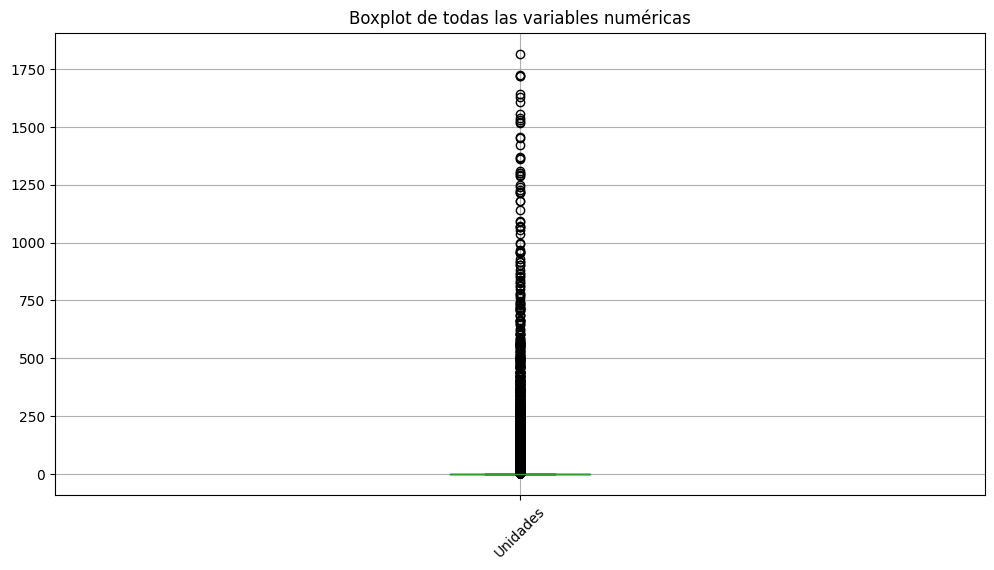

In [16]:
clean_data.boxplot(figsize=(12, 6))
plt.title("Boxplot de todas las variables numéricas")
plt.xticks(rotation=45)
plt.show()


Hay varios valores atípicos; eliminémoslos utilizando el Rango Intercuartílico (IQR).

In [12]:
def clean_outliers(df, col_interes='Unidades'):
    Q1 = df[col_interes].quantile(0.25)
    Q3 = df[col_interes].quantile(0.75)
    
    RI = Q3 - Q1
    lim_inf_MC = Q1 - 1.5 * RI
    lim_sup_MC = Q3 + 1.5 * RI
    
    mask = df[col_interes].between(lim_inf_MC, lim_sup_MC, inclusive='both') | df[col_interes].isna()
    return df[mask]

def process_data_groupby(clean_data):
    data_gold = clean_data.groupby('Cliente', group_keys=False).apply(
        lambda x: clean_outliers(x, col_interes='Unidades')
    ).reset_index(drop=True)
    return data_gold

data_gold = process_data_groupby(clean_data)

# Verificar resultados
print(f"Filas originales: {len(clean_data)}")
print(f"Filas después de limpiar outliers: {len(data_gold)}")

Filas originales: 5157158
Filas después de limpiar outliers: 5016988


/tmp/ipykernel_6772/1945536447.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_gold = clean_data.groupby('Cliente', group_keys=False).apply(


# Feature engineering

Ahora que tenemos una visión general de los datos, procedamos a crear un nuevo conjunto en el que cada fecha se ajuste al viernes de su semana correspondiente. A continuación, sumaremos todas las unidades enviadas durante esa semana para cada cliente. El objetivo es obtener envíos semanales por cliente.

In [13]:
data_gold["Semana_Viernes"] = data_gold["Fecha_Entrega"] + pd.offsets.Week(weekday=4)

df_sem = (
    data_gold.groupby(["Cliente", "Semana_Viernes"])["Unidades"]
      .sum()
      .reset_index()
      .rename(columns={"Unidades": "Unidades_Semanales"})
)
df_sem.head()

,Cliente,Semana_Viernes,Unidades_Semanales
0,AA-,2024-01-19,1
1,AA-,2024-02-16,1
2,AA-,2024-05-31,1
3,AA-,2024-08-02,2
4,AA-,2025-05-09,1


Perfecto, establezcamos la función para graficar las series temporales y comparemos.

In [14]:
def plot_time_series(df, x_var, y_var, title, xaxis_title, yaxis_title,dash='dash'):
    if not df[x_var].dtype.name.startswith('datetime'):
        df[x_var] = pd.to_datetime(df[x_var])
    fig = go.Figure()

    # Agregar la serie con línea punteada
    fig.add_trace(go.Scatter(
        x=df[x_var],
        y=df[y_var],
        mode='lines',
        name=y_var.replace('_', ' ').capitalize(),
        line=dict(color='blue', width=2, dash=dash)
    ))

    # Actualizar diseño
    fig.update_layout(
        title=f'<b>{title}</b>',
        title_font=dict(size=20, family='Arial', color='black'),
        xaxis_title=f'<b>{xaxis_title}</b>',
        yaxis_title=f'<b>{yaxis_title}</b>',
        font=dict(family='Arial', size=12, color='black'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='x unified',
        height=400,
        margin=dict(l=50, r=50, b=50, t=80)
    )

    # Formato año-mes en eje x
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', tickformat='%Y-%m')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    fig.show()
    return fig

In [15]:
data_gold = data_gold.sort_values(by=['Cliente','Fecha_Entrega'])
data_gold.head()

,Cliente,Producto,Fecha_Entrega,Unidades,Semana_Viernes
0,AA-,Paquetería,2024-01-12,1,2024-01-19
1,AA-,Paquetería,2024-02-14,1,2024-02-16
2,AA-,Paquetería,2024-05-27,1,2024-05-31
3,AA-,Paquetería,2024-07-27,1,2024-08-02
4,AA-,Paquetería,2024-07-29,1,2024-08-02


Perfecto, veamos las series temporales y verifiquemos si es mejor predecir las entregas diarias o las entregas semanales.

In [16]:
fig =plot_time_series(data_gold[data_gold['Cliente']=='AB-IDAADBIEJ'],
                       'Fecha_Entrega', 'Unidades', 
                 title='Envíos por día',
                 xaxis_title='Fecha',
                 yaxis_title='Unidades',
                     dash='dash')

In [17]:
fig =plot_time_series(df_sem[df_sem['Cliente']=='AB-IDAADBIEJ'],
                       'Semana_Viernes', 'Unidades_Semanales', 
                 title='Envíos semanales',
                 xaxis_title='Fecha',
                 yaxis_title='Unidades',
                     dash='dash')

Podemos observar que predecir los envíos diarios resulta bastante complejo. Por ello, optaremos por trabajar con el conjunto de datos que contiene los envíos semanales. 

Liberemos memoria y guardamenos este dataset.

In [18]:
del clean_data,data_entregas,data_gold
dir_save_data = project_root/'data/processed'
df_sem.to_parquet(dir_save_data/ 'Dataset_entregas_semanales_clientes.parquet', index=False)
gc.collect()

273

Perfecto, ahora veamos cuantos datos hay por serie temporal.

In [19]:
count_data = df_sem.groupby(['Cliente', 'Unidades_Semanales']).size().reset_index(name='count')
count_data.head(10)

,Cliente,Unidades_Semanales,count
0,AA-,1,6
1,AA-,2,2
2,AA-AAAAABAA,1,1
3,AA-AAAAABBBBBBB,1,1
4,AA-AAABAJIHIADBH,1,1
5,AA-AABAGFFIIAG,6,1
6,AA-AABAJIHDFCCIB,1,1
7,AA-AABAJIHIADBHA,3,1
8,AA-AABAJIHIADBHAAA,1,1
9,AA-AABAJIHIBADA,1,1


In [20]:
print(f"Mínima cantidad de resgistos en las series: {count_data['count'].min()}")
print(f"Máxima cantidad de resgistos en las series: {count_data['count'].max()}")

Mínima cantidad de resgistos en las series: 1
Máxima cantidad de resgistos en las series: 81


In [21]:
longitudes = (
    df_sem.groupby("Cliente")["Semana_Viernes"]
          .count()
          .reset_index(name="n_semanas")
)
distribucion = longitudes["n_semanas"].value_counts().sort_index()
distribucion

n_semanas
1     58624
2      9500
3      3779
4      1949
5      1270
      ...  
94       21
95       28
96       35
97       55
98      214
Name: count, Length: 98, dtype: int64

Vamos a quedarnos con los clientes que tienen al menos 6 meses en registros, esto involucra quedanos con clientes que tengas 24 semanas aproximadamente.

In [22]:
clientes_validos = longitudes[ longitudes["n_semanas"] >= 24 ]["Cliente"]

df_filtrado = df_sem[df_sem["Cliente"].isin(clientes_validos)].copy()

In [23]:
df_filtrado['Cliente'].unique()

array(['AA-B', 'AA-BAAABIIHJG', 'AA-BAAAEEBIHC', ..., 'EI-IJAJAAJED',
       'FG-IJAJAAJED', 'GC-IJAJAAJED'], shape=(2579,), dtype=object)

In [24]:
fig =plot_time_series(df_filtrado[df_filtrado['Cliente']=='AB-IDAADBIEJ'],
                       'Semana_Viernes', 'Unidades_Semanales', 
                 title='Envíos semanales',
                 xaxis_title='Fecha',
                 yaxis_title='Unidades',
                     dash='dash')

Perfecto, ahora veamos si modelos basados en árboles de decisón pueden predecir estas series temporales.

Para eso cremos dos dataframes, uno para arboles de desicón y otro para modelos como prophet.

# Modelado

## Arboles de decision

Antes de implementar los modelos vamos garantizar que las series de tiempo sean continuas. Para esto:

- Rellenar los períodos semanales sin datos de envios con 0 (asumiendo que no hubo envios en esas semanas), esto asegura que todas las combinaciones de cliente tengan un registro semanal continuo (incluso si no hubo envios en ciertas semanas).

In [25]:
del df_sem

df = df_filtrado.copy()
def completar_series_temporales(df):
    df_sorted = df.sort_values(['Cliente', 'Semana_Viernes'])
    
    # Asegurar que Semana_Viernes sea datetime
    df_sorted['Semana_Viernes'] = pd.to_datetime(df_sorted['Semana_Viernes'])
    
    resultados = []

    for cliente, subdf in df_sorted.groupby('Cliente'):
        # Verificar que hay suficientes datos
        if len(subdf) == 0:
            continue
            
        # Generar rango completo semanal
        fechas = pd.date_range(
            start=subdf['Semana_Viernes'].min(),
            end=subdf['Semana_Viernes'].max(),
            freq='W-FRI'
        )
        
        # DataFrame base
        base = pd.DataFrame({
            'Cliente': cliente,
            'Semana_Viernes': fechas
        })

        # Merge y rellenar
        merged = base.merge(
            subdf[['Cliente', 'Semana_Viernes', 'Unidades_Semanales']], 
            on=['Cliente', 'Semana_Viernes'], 
            how='left'
        )
        
        merged['Unidades_Semanales'] = merged['Unidades_Semanales'].fillna(0).astype(int)
        
        resultados.append(merged)

    return pd.concat(resultados, ignore_index=True)

df = completar_series_temporales(df_filtrado)


In [26]:
df['day'] = df['Semana_Viernes'].dt.day
df['month'] = df['Semana_Viernes'].dt.month
df['year'] = df['Semana_Viernes'].dt.year
df['week'] = df['Semana_Viernes'].dt.isocalendar().week

clientes_unicos = df['Cliente'].unique()

dict_clientes = {cliente: idx for idx, cliente in enumerate(clientes_unicos)}
df['Cliente'] = df['Cliente'].map(dict_clientes)

df.head()

,Cliente,Semana_Viernes,Unidades_Semanales,day,month,year,week
0,0,2024-01-05,2,5,1,2024,1
1,0,2024-01-12,0,12,1,2024,2
2,0,2024-01-19,0,19,1,2024,3
3,0,2024-01-26,1,26,1,2024,4
4,0,2024-02-02,1,2,2,2024,5


In [27]:
print(f"envios totales originales {df_filtrado['Unidades_Semanales'].sum()}")
print(f"envios totales con corrección de frencia temporal {df['Unidades_Semanales'].sum()}")

envios totales originales 5062365
envios totales con corrección de frencia temporal 5062365


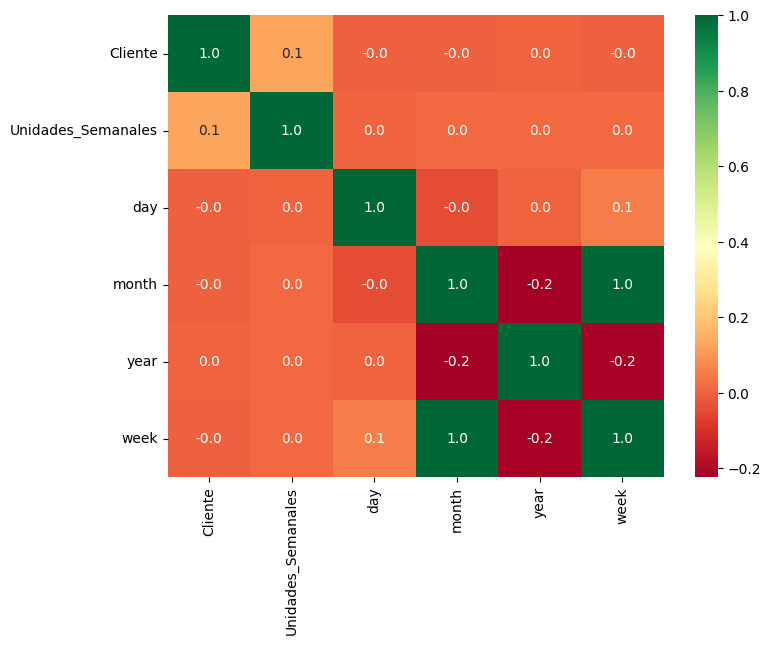

In [28]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    df.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

In [29]:
n_test = 6

test = (
    df.sort_values(["Cliente", "Semana_Viernes"])
          .groupby("Cliente")
          .tail(n_test)
          .reset_index(drop=True)
)

train = (
    df.merge(
        test[["Cliente", "Semana_Viernes"]],
        on=["Cliente", "Semana_Viernes"],
        how="left",
        indicator=True
    )
    .query('_merge == "left_only"')
    .drop(columns="_merge")
    .reset_index(drop=True)
)

In [30]:
X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_train = train["Unidades_Semanales"]

X_test  = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_test  = test["Unidades_Semanales"]

In [31]:
def model(y_test, y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, y_train)
    y_pred = np.ceil(model_instance.predict(X_test)).astype(int) 

    # ---- MÉTRICAS ----
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100
    mask = (y_test != 0) & (~np.isnan(y_test))
    if mask.sum() > 0:
        mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask])
    else:
        mape = np.nan
    print('-----------------')
    print(model.__name__)
    print('-----------------')
    print(f'MSE : {mse}')
    print(f'MAE : {mae}')
    print(f'R2  : {round(r2, 2)} %')
    if not np.isnan(mape):
        print(f'MAPE: {mape:.4f}')
    else:
        print("MAPE: No disponible (valores reales = 0)")
    return model_instance
x = [model(y_test, y_train, X_test, X_train, i) for i in [
    RandomForestRegressor,
    GradientBoostingRegressor,
    XGBRegressor
]]

-----------------
RandomForestRegressor
-----------------
MSE : 6478.7237301279565
MAE : 12.077614062298048
R2  : 76.43 %
MAPE: 1.9842
-----------------
GradientBoostingRegressor
-----------------
MSE : 11053.974796432725
MAE : 27.45909267157813
R2  : 59.78 %
MAPE: 7.8813
-----------------
XGBRegressor
-----------------
MSE : 25778.33889104304
MAE : 42.16505105337986
R2  : 6.21 %
MAPE: 12.8732


Ok, podemos ver que RandomForestRegressor captura el 76,37% de la varibilidad de los datos. Veamos si podemos mejorar esto.

In [32]:
gc.collect()

7044

## hyperparameter optimization

### RandomForestRegressor

In [ ]:
def optimizar_rf_holdout(trial, df, n_test=6):

    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    X_valid = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_valid = test["Unidades_Semanales"]
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1,
        'random_state': 42
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return r2_score(y_valid, y_pred)


In [59]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: optimizar_rf_holdout(trial, df), n_trials=60)

[I 2025-11-17 18:11:28,242] A new study created in memory with name: no-name-8fe70052-63b1-4991-8d20-573c7958a2ca
[I 2025-11-17 18:11:32,128] Trial 0 finished with value: 0.3209434710583696 and parameters: {'n_estimators': 143, 'max_depth': 16, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.3209434710583696.
[I 2025-11-17 18:11:32,739] Trial 1 finished with value: 0.5230266902853684 and parameters: {'n_estimators': 24, 'max_depth': 6, 'max_features': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.5230266902853684.
[I 2025-11-17 18:11:33,715] Trial 2 finished with value: 0.08799820929413738 and parameters: {'n_estimators': 132, 'max_depth': 2, 'max_features': 0.8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.5230266902853684.
[I 2025-11-17 18:11:34,213] Trial 3 finished with value: 0.08734470007822637 and p

In [60]:
print(study_rf.best_params)
print(study_rf.best_value)

{'n_estimators': 72, 'max_depth': 16, 'max_features': 1.0, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}
0.766527387707465


In [61]:
gc.collect()

432

Perfecto, evaluemos nuestro modelo

# Evaluacion

Con los parámetros óptimos encontrados, evaluaremos el desempeño del modelo.

In [33]:
X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_train = train["Unidades_Semanales"]

X_test  = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_test  = test["Unidades_Semanales"]

def model_fit(X_train, y_train, X_test, y_test, model_class):
    model_instance = model_class()
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    # MÉTRICAS
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred) * 100

    mask = (y_test != 0) & (~np.isnan(y_test))
    mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) if mask.sum() > 0 else np.nan

    print('-----------------')
    print(model_class.__name__)
    print('-----------------')
    print(f'MSE : {mse}')
    print(f'MAE : {mae}')
    print(f'R2  : {round(r2, 2)} %')
    print(f'MAPE: {mape if not np.isnan(mape) else "No disponible (valores reales = 0)"}')

    return model_instance

In [34]:
params={'n_estimators': 72, 
        'max_depth': 16, 
        'max_features': 1.0, 
        'min_samples_split': 3, 
        'min_samples_leaf': 2, 
        'bootstrap': True}
models = [
    lambda: RandomForestRegressor(**params)
]
results = [
    model_fit(X_train, y_train, X_test, y_test, m)
    for m in models
]

-----------------
<lambda>
-----------------
MSE : 6413.454605758665
MAE : 14.059247363732574
R2  : 76.67 %
MAPE: 2.8203238089417977


Bueno, veamos las predicciones.

## Predicciones

In [35]:
model = RandomForestRegressor(**params)
model.fit(X_train, y_train)

train['prediccion'] = np.ceil(model.predict(X_train)).astype(int)

# error absoluto 
train["error"] = y_train - train["prediccion"]
train["abs_error"] = train["error"].abs()


# Distribución de los errores por serie
quantiles = (
    train.groupby(["Cliente"])["error"]
      .quantile([0.05, 0.95])
      .unstack()
)
quantiles.columns = ["q05_error", "q95_error"]

In [36]:
train = train.merge(
    quantiles,
    on=["Cliente"],
    how="left"
)

train["pred_lower"] = train["prediccion"] + train["q05_error"]
train["pred_upper"] = train["prediccion"] + train["q95_error"]

# Mae
mae_series = (
    train.groupby(["Cliente",])["abs_error"]
      .mean()
      .reset_index()
      .rename(columns={"abs_error": "MAE"})
)

train = train.merge(mae_series, on=["Cliente"], how="left")

In [37]:
def plot_confidence_styled(df, Cliente):
    
    df_plot = df[
        df["Cliente"] == Cliente
    ].sort_values("Semana_Viernes")

    mae_value = df_plot["MAE"].iloc[0] 

    fig = go.Figure()

    # --- Banda de confianza ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["pred_upper"],
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["pred_lower"],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(0, 100, 255, 0.20)',
        line=dict(width=0),
        name='Intervalo de confianza'
    ))

    # --- Predicción ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["prediccion"],
        mode='lines',
        name='Predicción',
        line=dict(color='red', width=2, dash='dash')
    ))

    # --- Real ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["Unidades_Semanales"],
        mode='lines',
        name='Datos Reales',
        line=dict(color='blue', width=2, dash='solid')
    ))

    # --- Layout estilo mejorado ---
    fig.update_layout(
        title=f"<b>Cliente={Cliente} |  MAE={mae_value:.2f}</b>",
        title_font=dict(size=20, family='Arial', color='black'),
        xaxis_title="<b>Fecha</b>",
        yaxis_title="<b>Unidades</b>",
        font=dict(family='Arial', size=12, color='black'),
        plot_bgcolor="white",
        paper_bgcolor="white",
        hovermode="x unified",
        height=450,
        margin=dict(l=50, r=50, b=50, t=80)
    )

    # --- Estilo de ejes ---
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', tickformat='%Y-%m')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    return fig

Veamos como predice los datos vistos.

In [38]:
dict_clientes_inverso = {idx: cliente for cliente, idx in dict_clientes.items()}

# Revertir la codificación en el DataFrame
train['Cliente'] = train['Cliente'].map(dict_clientes_inverso)

In [39]:
plot_confidence_styled(train, Cliente='AB-IJAIABDDJ')

In [40]:
plot_confidence_styled(train, Cliente='AB-IDAADBIEJ')

El modelo tiene un buen ajuste, pero no es el mejor. Veamos las prediccione.

In [41]:
test['prediccion'] = np.ceil(model.predict(X_test)).astype(int)
# error absoluto 
test["error"] = test["Unidades_Semanales"] - test["prediccion"]
test["abs_error"] = test["error"].abs()


# Distribución de los errores por serie
quantiles = (
    test.groupby(["Cliente"])["error"]
      .quantile([0.05, 0.95])
      .unstack()
)
quantiles.columns = ["q05_error", "q95_error"]

test = test.merge(
    quantiles,
    on=["Cliente"],
    how="left"
)

test["pred_lower"] = test["prediccion"] + test["q05_error"]
test["pred_upper"] = test["prediccion"] + test["q95_error"]

# Mae
mae_series = (
    test.groupby(["Cliente"])["abs_error"]
      .mean()
      .reset_index()
      .rename(columns={"abs_error": "MAE"})
)

test = test.merge(mae_series, on=["Cliente"], how="left")

In [42]:
test['Cliente'] = test['Cliente'].map(dict_clientes_inverso)

In [43]:
plot_confidence_styled(test, Cliente='AB-IJAIABDDJ')

In [44]:
plot_confidence_styled(test, Cliente='AA-BAADDJEJAA')

Ok, ya conocemos el comportamiento del modelo cuando se entrena sin las últimas seis semanas de datos de cada cliente.

Ahora que contamos con los mejores parámetros, entrenemos el modelo con todos los datos disponibles y, para cada cliente, realicemos la predicción de las próximas seis semanas.

In [45]:
gc.collect()

17

In [46]:
df.head()

,Cliente,Semana_Viernes,Unidades_Semanales,day,month,year,week
0,0,2024-01-05,2,5,1,2024,1
1,0,2024-01-12,0,12,1,2024,2
2,0,2024-01-19,0,19,1,2024,3
3,0,2024-01-26,1,26,1,2024,4
4,0,2024-02-02,1,2,2,2024,5


In [47]:
fullmodel = RandomForestRegressor(**params)
independientes = df.drop(columns=['Semana_Viernes','Unidades_Semanales'])
objetivo = df['Unidades_Semanales']

fullmodel.fit(independientes, objetivo)

,n_estimators,72
,criterion,'squared_error'
,max_depth,16
,min_samples_split,3
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Ahora generemos las fechas a las cuales necesitamos hacer las predicciones.

In [48]:
df['Semana_Viernes'].max()

Timestamp('2025-11-14 00:00:00')

In [87]:
# Crear fechas para las próximas 6 semanas
ultima_fecha = df['Semana_Viernes'].max()
semanas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(weeks=1), 
                               periods=6, freq='W-FRI')

# Crear DataFrame con todas las combinaciones cliente x semana
clientes_unicos = df['Cliente'].unique()
datos_futuros = []

for cliente in clientes_unicos:
    for semana in semanas_futuras:
        datos_futuros.append({
            'Cliente': cliente,
            'Semana_Viernes': semana,
            'day': semana.day,
            'month': semana.month,
            'year':semana.year,
            'week':semana.isocalendar().week
        })

df_futuro = pd.DataFrame(datos_futuros)
df_futuro.head(10)

,Cliente,Semana_Viernes,day,month,year,week
0,0,2025-11-21,21,11,2025,47
1,0,2025-11-28,28,11,2025,48
2,0,2025-12-05,5,12,2025,49
3,0,2025-12-12,12,12,2025,50
4,0,2025-12-19,19,12,2025,51
5,0,2025-12-26,26,12,2025,52
6,1,2025-11-21,21,11,2025,47
7,1,2025-11-28,28,11,2025,48
8,1,2025-12-05,5,12,2025,49
9,1,2025-12-12,12,12,2025,50


Obtengamos las predicciones

In [88]:
df_futuro_c = df_futuro.copy()
df_futuro_b = df_futuro.copy()
df_futuro = df_futuro.drop(columns=['Semana_Viernes'],axis=1)
df_futuro['Unidades_esperadas'] = np.ceil(fullmodel.predict(df_futuro)).astype(int)
df_futuro.head()

,Cliente,day,month,year,week,Unidades_esperadas
0,0,21,11,2025,47,1
1,0,28,11,2025,48,1
2,0,5,12,2025,49,1
3,0,12,12,2025,50,1
4,0,19,12,2025,51,1


Vamos aunir el dataframe los dos dataframes, el que contiene las predicciones futuras y el dataframe que contiene el historico.


In [89]:
df_futuro_b['Unidades_Semanales'] = df_futuro['Unidades_esperadas']
# concatenemos las predicciones con el dataframe histórico.
df_full = pd.concat([df,df_futuro_b],axis=0)
df_full = df_full.sort_values(by=['Cliente','Semana_Viernes'])
df_full.head()

,Cliente,Semana_Viernes,Unidades_Semanales,day,month,year,week
0,0,2024-01-05,2,5,1,2024,1
1,0,2024-01-12,0,12,1,2024,2
2,0,2024-01-19,0,19,1,2024,3
3,0,2024-01-26,1,26,1,2024,4
4,0,2024-02-02,1,2,2,2024,5


In [90]:
df_futuro['Cliente'] = df_futuro['Cliente'].map(dict_clientes_inverso)

# Calculo del crecimiento proyectado

Vamos a tomar dos enfoques para calcular el crecimiento proyectado:

- El primero es calcularlo con respecto al último dato real y el ultimo dato predicho
- El segundo es que calularemos el incremento porcentual de toda la serie.

In [91]:
ultimo_valor_real = (
    df.groupby("Cliente")
           .tail(1)[["Cliente", "Semana_Viernes", "Unidades_Semanales"]]
           .reset_index(drop=True)
)
ultimo_valor_real['Cliente'] = ultimo_valor_real['Cliente'].map(dict_clientes_inverso)
ultimo_valor_real.head()

,Cliente,Semana_Viernes,Unidades_Semanales
0,AA-B,2025-09-05,1
1,AA-BAAABIIHJG,2025-11-14,10
2,AA-BAAAEEBIHC,2025-10-10,1
3,AA-BAAAFFCH,2025-11-14,1
4,AA-BAAAFHAAJF,2025-04-18,2


Ahora obtengamos el ultimo valor predicho para cada cliente.

In [92]:
df_futuro_c['Cliente'] = df_futuro_c['Cliente'].map(dict_clientes_inverso)
df_futuro_c['Unidades_esperadas'] = df_futuro['Unidades_esperadas']
ultimo_valor_pre = (
    df_futuro_c .groupby("Cliente")
           .head(1)[["Cliente", "Semana_Viernes", "Unidades_esperadas"]]
           .reset_index(drop=True)
)

Ahora si, calculemos el crecimiento proyectado, teniendo en cuenta el ultimo dato real de cada cliente y el ultimo envio pronosticado.


In [93]:
ultimo_valor_real= ultimo_valor_real.sort_values(by="Cliente").reset_index(drop=True)
ultimo_valor_pre= ultimo_valor_pre.sort_values(by="Cliente").reset_index(drop=True)

print(f"cantidad registros en valor real {ultimo_valor_pre.shape[0]}")
print(f"cantidad registros en valor futuro {ultimo_valor_real.shape[0]}")

cantidad registros en valor real 2579
cantidad registros en valor futuro 2579


In [94]:

crecimiento = pd.merge(ultimo_valor_pre, ultimo_valor_real[['Cliente', 'Unidades_Semanales']], on='Cliente')

crecimiento['Crecimiento_%'] = ((crecimiento['Unidades_esperadas'] / crecimiento['Unidades_Semanales']) - 1)
crecimiento.head()

,Cliente,Semana_Viernes,Unidades_esperadas,Unidades_Semanales,Crecimiento_%
0,AA-B,2025-11-21,1,1,0.00
1,AA-BAAABIIHJG,2025-11-21,19,10,0.90
2,AA-BAAAEEBIHC,2025-11-21,1,1,0.00
3,AA-BAAAFFCH,2025-11-21,6,1,5.00
4,AA-BAAAFHAAJF,2025-11-21,1,2,-0.50


In [95]:
crecimiento['Crecimiento_%'].max()

np.float64(719.0)

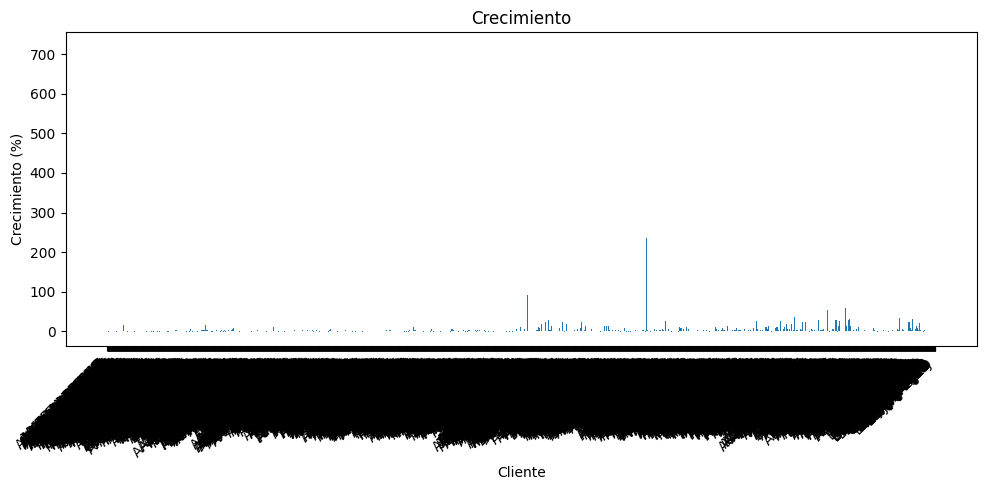

In [67]:
plt.figure(figsize=(10,5))
plt.bar(crecimiento["Cliente"], crecimiento["Crecimiento_%"])
plt.xlabel("Cliente")
plt.ylabel("Crecimiento (%)")
plt.title("Crecimiento")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Ahora calculemos el crecimiento porcentual de cada serie con respecto a toda su serie temporal.

In [96]:
df_full = df_full.set_index('Semana_Viernes')
df_full['Cliente'] = df_full['Cliente'].map(dict_clientes_inverso)
df_full.head()

,Cliente,Unidades_Semanales,day,month,year,week
Semana_Viernes,,,,,,
2024-01-05,AA-B,2,5,1,2024,1
2024-01-12,AA-B,0,12,1,2024,2
2024-01-19,AA-B,0,19,1,2024,3
2024-01-26,AA-B,1,26,1,2024,4
2024-02-02,AA-B,1,2,2,2024,5


In [141]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def STS_plotly_express(df, cliente, window, porcentaje):
    data = df[df['Cliente'] == cliente].copy()
    
    # Calcular métricas
    data.loc[:, 'media_movil'] = data['Unidades_Semanales'].rolling(window=window).mean()
    data.loc[:, 'cambio porcentual'] = 100 * ((data['Unidades_Semanales'] - data['media_movil']) / data['media_movil'])
    outliers = data[data['cambio porcentual'] >= porcentaje]
    
    # Separar últimos 6 puntos (incluyendo el punto de conexión)
    ultimo_historico = len(data) - 6
    data_historico = data.iloc[:ultimo_historico]
    data_pronostico = data.iloc[ultimo_historico-1:]  # Incluir el último punto histórico para conectar
    
    # Crear figura con subplots
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Unidades Semanales y Cambio Porcentual', 
                       'Cambio Porcentual', 
                       'Distribución del Cambio Porcentual'),
        vertical_spacing=0.08,
        row_heights=[0.5, 0.5]
    )
    
    # Gráfico 1: Líneas - Unidades Semanales
    fig.add_trace(
        go.Scatter(x=data_historico.index, y=data_historico['Unidades_Semanales'], 
                  name='Unidades semanales', line=dict(dash='dash', color='blue')),
        row=1, col=1
    )
    
    # Últimos 6 puntos en rojo (conectados al histórico)
    fig.add_trace(
        go.Scatter(x=data_pronostico.index, y=data_pronostico['Unidades_Semanales'], 
                  name='Pronósticos', line=dict(dash='dash', color='red')),
        row=1, col=1
    )
    
    # Gráfico 2: Cambio porcentual
    fig.add_trace(
        go.Scatter(x=data_historico.index, y=data_historico['cambio porcentual'],
                  name='Cambio porcentual', line=dict(dash='dash', color='green')),
        row=2, col=1
    )
    
    # Últimos 6 puntos en naranja (conectados al histórico)
    fig.add_trace(
        go.Scatter(x=data_pronostico.index, y=data_pronostico['cambio porcentual'],
                  name='Cambio % pronóstico', line=dict(dash='dash', color='orange')),
        row=2, col=1
    )
    
    fig.add_hline(y=data['cambio porcentual'].mean(), line_dash="dash", line_color="red",
                  annotation_text="Promedio", row=2, col=1)
    
    """
    # Gráfico 3: Boxplot 
    fig.add_trace(
        go.Box(y=data['cambio porcentual'].dropna(), name='', 
               marker_color='yellowgreen', opacity=0.4),
        row=3, col=1
    )
    """
    
    fig.update_layout(
        title_text=cliente,
        title_x=0.5,
        height=600,
        showlegend=True,
        template='plotly_white'
    )
    
    fig.show()

In [142]:
STS_plotly_express(df=df_full,
    cliente='AB-IDAADBIEJ',
    window=2,
    porcentaje=20)

In [143]:
STS_plotly_express(df=df_full,
    cliente='GC-IJAJAAJED',
    window=2,
    porcentaje=20)